In [1]:
!pip install transformers
!pip install evaluate
!pip install seqeval
!pip install huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.

In [ ]:
import numpy as np
import pandas as pd
import random
import evaluate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from seqeval.metrics import precision_score, recall_score, f1_score, accuracy_score

import transformers
from transformers import AutoTokenizer, DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification, Trainer, TrainingArguments
from datasets import load_dataset, DatasetDict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

from huggingface_hub import login
import os
import getpass

In [5]:
btc_dataset = load_dataset('tner/btc')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.86k [00:00<?, ?B/s]

btc.py:   0%|          | 0.00/3.91k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/494k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/77.7k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/180k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6338 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1001 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Example tweets: 

['I', 'hate', 'the', 'words', 'chunder', ',', 'vomit', 'and', 'puke', '.', 'BUUH', '.']
['♥', '.', '.', ')', ')', '(', '♫', '.', '(', 'ړײ', ')', '♫', '.', '♥', '.', '«', '▓', '»', '♥', '.', '♫', '.', '.', '╝', '╚', '.', '.', '♫', 'Happy', 'New', 'Year']
['Alesan', 'kenapa', 'mlm', 'kita', 'lbh', 'srg', 'galau', 'Poconggg', '\'"\'', 'TwitFAKTA', ':', 'Otak', 'lebih', 'aktif', 'di', 'malam', 'hari', 'dari', 'pada', 'di', 'pagi', 'hari', '.', '#', 'TwitFAKTA', '\'"\'']
Example labels: 

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

Train Size: 6338
Test Size: 2000


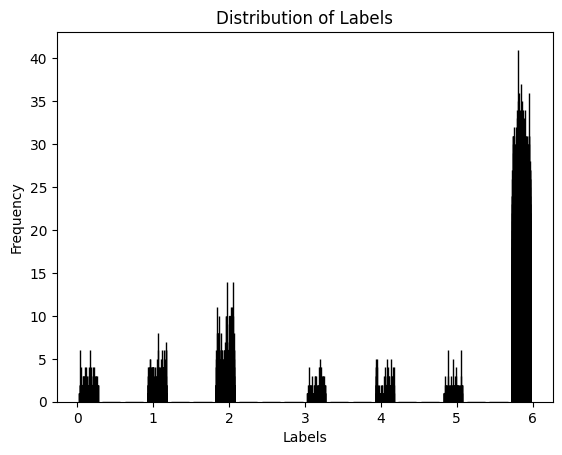

In [6]:
# Load train and test
train_dataset = btc_dataset['train']
test_dataset = btc_dataset['test']

# Display example tweets
print("Example tweets: \n")
for example in train_dataset['tokens'][:3]:
    print(example)

# Display example labels
print("Example labels: \n")
for label in train_dataset['tags'][:3]:
    print(label)

# Check train/test splits
train_size = len(train_dataset)
test_size = len(test_dataset)
print(f"\nTrain Size: {train_size}")
print(f"Test Size: {test_size}")

# Visualize the distribution of labels
labels = test_dataset['tags']
plt.hist(labels, bins=round(len(labels)/100), edgecolor='black')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()

In [7]:
# Create validation set from train set

split_datasets = btc_dataset['train'].train_test_split(train_size=0.7, seed=42)
btc_with_validation_dataset = DatasetDict({
    'train': split_datasets['train'],
    'validation': split_datasets['test'],
    'test': btc_dataset['test']
})
btc_with_validation_dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 4436
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 1902
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 2000
    })
})

In [8]:
# Load tokenizer

model_checkpoint = "distilbert/distilbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

print(tokenizer.is_fast)

# Print tokens and word IDs of an example of the training set
inputs = tokenizer(btc_with_validation_dataset["train"][0]["tokens"], is_split_into_words=True)
print(inputs.tokens(), '\n', inputs.word_ids())

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

True
['[CLS]', '@', 'ni', '##gel', '##ly', '##mi', '##lk', 'H', '##A', '##HA', '##H', '##HA', '##A', 'S', '##I', '##Y', '##A', 'N', '##GA', 'P', '##I', '100', 'K', '##O', 'N', '##A', '##KA', '##KA', '##IN', '##IS', '[SEP]'] 
 [None, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 5, 5, 6, 7, 7, 8, 8, 8, 8, 8, 8, None]


In [9]:
# Align word-level labels with subword tokens after tokenization.

def label_token_alignment(labels, word_ids):
    prev_label = None
    updated_labels = []
    for word_id in word_ids:
        if word_id is None:
            # Special token
            updated_labels.append(-100)

        elif word_id != prev_label:
            # Start of a new word!
            prev_label = word_id
            label = -100 if word_id is None else labels[word_id]
            updated_labels.append(label)
        else:
            # Same word as the previous token
            prev_label = updated_labels[-1]
            if prev_label in ['B-LOC', 'B-ORG', 'B-PER']:
                label = 'I' + prev_label[1:]
            else:
                label = prev_label
            updated_labels.append(label)

    return updated_labels


In [10]:
def tokenize_align_labels(examples):
    inputs_tokenized = tokenizer(examples["tokens"], is_split_into_words=True, truncation=True)
    updated_labels = []
    labels = examples["tags"]
    for i, labels in enumerate(labels):
        word_ids = inputs_tokenized.word_ids(i)
        updated_labels.append(label_token_alignment(labels, word_ids))

    inputs_tokenized["labels"] = updated_labels
    return inputs_tokenized


In [11]:
tokenized_datasets = btc_with_validation_dataset.map(
    tokenize_align_labels,
    batched=True,
    remove_columns=btc_with_validation_dataset["train"].column_names,
)

Map:   0%|          | 0/4436 [00:00<?, ? examples/s]

Map:   0%|          | 0/1902 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [14]:
# Define a Transformer model for NER
class TransformerNER(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_encoder_layers, num_classes, max_seq_length):
        super(TransformerNER, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = nn.Parameter(torch.randn(max_seq_length, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, input_ids, mask):
        embeddings = self.embedding(input_ids) + self.positional_encoding[:input_ids.size(-1), :]
        transformer_out = self.transformer_encoder(embeddings, src_key_padding_mask=mask)
        logits = self.fc(transformer_out)
        return logits

In [15]:
# Define hyperparameters
embed_dim = 256
num_heads = 2
num_encoder_layers = 2

num_classes = 7     # Number of NER tags from the dataset
max_seq_length = 128  # Adjust this based on your dataset
vocab_size = 28996

# Instantiate the model
model = TransformerNER(vocab_size=vocab_size,
                       embed_dim=embed_dim,
                       num_heads=num_heads,
                       num_encoder_layers=num_encoder_layers,
                       num_classes=num_classes,
                       max_seq_length=max_seq_length)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [16]:
# Define a collate function to handle variable-length sequences
def collate_fn(batch):
    input_ids = [torch.tensor(item['input_ids']) for item in batch]
    target_tags = [torch.tensor(item['labels']) for item in batch]
    mask = [torch.tensor(item['attention_mask'], dtype=torch.float32) for item in batch]  # Convert mask to float32

    # Pad sequences to the maximum length in the batch
    # Output shhape -> Batch size, max_seq_len
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    target_tags = pad_sequence(target_tags, batch_first=True, padding_value=-100)  # Assuming -100 is the padding value for labels
    mask = pad_sequence(mask, batch_first=True, padding_value=0)  # Assuming 0 is the padding value for attention mask

    return {
        'input_ids': input_ids,
        'labels': target_tags,
        'attention_mask': mask
    }

# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

batch_size = 8

# Create DataLoader with the collate function
train_loader = DataLoader(tokenized_datasets["train"],
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=collate_fn)


In [23]:
for epoch in range(30):
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for batch in train_loader:
        input_ids = batch['input_ids']
        target_tags = batch['labels']
        mask = batch['attention_mask']

        # Forward pass
        outputs = model(input_ids, mask.transpose(0, 1))  # Transpose mask tensor to match the expected shape
        active_loss = mask.view(-1) == 1  # Flatten the mask tensor
        # Skip padding tokens for loss calculation
        active_logits = outputs.view(-1, num_classes)[active_loss]
        active_labels = target_tags.view(-1)[active_loss]
        loss = loss_function(active_logits, active_labels)

        # Compute accuracy
        _, predicted = torch.max(outputs, -1)
        correct = (predicted == target_tags) & (target_tags != -100)  # Exclude padded tokens from accuracy calculation
        total_correct += correct.sum().item()
        total_samples += torch.sum(target_tags != -100).item()  # Exclude padded tokens from total samples

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}, Accuracy: {total_correct / total_samples}")

Epoch 1, Loss: 0.5297438650920584, Accuracy: 0.873222848489947
Epoch 2, Loss: 0.47564881760794836, Accuracy: 0.8768861322911966
Epoch 3, Loss: 0.45099940061032234, Accuracy: 0.8779338773449987
Epoch 4, Loss: 0.42717442292350905, Accuracy: 0.8798687641961807
Epoch 5, Loss: 0.41007438793375683, Accuracy: 0.882277813042514
Epoch 6, Loss: 0.39756514768342716, Accuracy: 0.8839220844773129
Epoch 7, Loss: 0.38222407003243764, Accuracy: 0.8872947528621795
Epoch 8, Loss: 0.37268209284221804, Accuracy: 0.8895508462262058
Epoch 9, Loss: 0.36481983354231257, Accuracy: 0.8920287250395772
Epoch 10, Loss: 0.35828723276520635, Accuracy: 0.8925028870347286
Epoch 11, Loss: 0.3567533525797698, Accuracy: 0.8937265308931835
Epoch 12, Loss: 0.34587747731187324, Accuracy: 0.8961355797395169
Epoch 13, Loss: 0.34257613982971724, Accuracy: 0.8968544705063591
Epoch 14, Loss: 0.3310976852771935, Accuracy: 0.8993170537714998
Epoch 15, Loss: 0.3274242585508136, Accuracy: 0.9008236652722226
Epoch 16, Loss: 0.3209949

In [24]:
# Evaluation loop (with accuracy calculation)
# Create DataLoader with the collate function
validation_loader = DataLoader(tokenized_datasets["validation"],
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=collate_fn)

model.eval()
with torch.no_grad():
    total_correct_val = 0
    total_samples_val = 0
    for batch in validation_loader:
        #input_ids = torch.tensor(batch['input_ids'], dtype=torch.int64)
        #target_tags = torch.tensor(batch['labels'], dtype=torch.int64)
        #mask = torch.tensor(batch['attention_mask'], dtype=torch.float32)

        input_ids = batch['input_ids'].clone().detach().to(torch.int64)
        target_tags = batch['labels'].clone().detach().to(torch.int64)
        mask = batch['attention_mask'].clone().detach().to(torch.float32)

        # Forward pass
        outputs = model(input_ids, mask.transpose(0, 1))

        # Compute accuracy
        _, predicted = torch.max(outputs, -1)
        correct = (predicted == target_tags) & (target_tags != -100)  # Exclude padded tokens from accuracy calculation
        total_correct_val += correct.sum().item()
        total_samples_val += torch.sum(target_tags != -100).item()  # Exclude padded tokens from total samples

    print(f"Validation Accuracy: {total_correct_val / total_samples_val}")

Validation Accuracy: 0.8832663660449529


In [25]:
ner_feature = btc_with_validation_dataset["train"].features["tags"]
label_names = ner_feature.feature.names
print(ner_feature, '\n', label_names)

id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}
print(id2label, '\n', label2id)

Sequence(feature=ClassLabel(names=['B-LOC', 'B-ORG', 'B-PER', 'I-LOC', 'I-ORG', 'I-PER', 'O'], id=None), length=-1, id=None) 
 ['B-LOC', 'B-ORG', 'B-PER', 'I-LOC', 'I-ORG', 'I-PER', 'O']
{0: 'B-LOC', 1: 'B-ORG', 2: 'B-PER', 3: 'I-LOC', 4: 'I-ORG', 5: 'I-PER', 6: 'O'} 
 {'B-LOC': 0, 'B-ORG': 1, 'B-PER': 2, 'I-LOC': 3, 'I-ORG': 4, 'I-PER': 5, 'O': 6}


In [26]:
model_checkpoint = "distilbert/distilbert-base-cased"

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert/distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
print(data_collator)

batch = data_collator([tokenized_datasets["train"][i] for i in range(2)])
print(batch["input_ids"], '\n', batch["labels"])

DataCollatorForTokenClassification(tokenizer=DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
), padding=True, max_length=None, pad_to_multiple_of=None, lab

In [28]:
def metrics_computations(eval_preds):
    logits, labels = eval_preds
    predicts = np.argmax(logits, axis=-1)

    # Skip padding or unknown token
    lab_true = [[label_names[lab] for lab in label if lab != -100] for label in labels]
    pred_true = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predicts, labels)
    ]

    accuracy = accuracy_score(lab_true, pred_true)
    recall = recall_score(lab_true, pred_true)
    precision = precision_score(lab_true, pred_true)
    f1 = f1_score(lab_true, pred_true)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy
    }

In [ ]:
access_token = getpass.getpass("Enter your huggingface access token: ")

In [ ]:
login(token = access_token)

args = TrainingArguments(
    "distilbert-base-cased",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=10,
    weight_decay=0.01,
    push_to_hub=True,
    hub_model_id='Amaan39/btc-ner'
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [30]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=metrics_computations,
    tokenizer=tokenizer,
)
trainer.train()

trainer.push_to_hub(commit_message="Training complete")

<ipython-input-30-60c399f13665>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: amaanrzv786 (amaanrzv786-research) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.289700,0.214621,0.595017,0.705338,0.645497,0.933378
2,0.158900,0.182843,0.677209,0.701068,0.688932,0.943695
3,0.111200,0.185840,0.692227,0.703559,0.697847,0.945309
4,0.080900,0.214071,0.692935,0.710320,0.701520,0.945590
5,0.059800,0.246312,0.694508,0.699822,0.697155,0.944765
6,0.039200,0.284229,0.710872,0.693416,0.702036,0.945958
7,0.028500,0.297522,0.671731,0.723843,0.696814,0.943940
8,0.020100,0.317024,0.690010,0.703025,0.696457,0.944695
9,0.017400,0.321357,0.703367,0.702491,0.702929,0.945467
10,0.010100,0.327074,0.692001,0.711210,0.701474,0.944941


CommitInfo(commit_url='https://huggingface.co/Amaan39/btc-ner/commit/8bf8975d61c3ba2017248ce9e8ca963ed21ab2d3', commit_message='Training complete', commit_description='', oid='8bf8975d61c3ba2017248ce9e8ca963ed21ab2d3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Amaan39/btc-ner', endpoint='https://huggingface.co', repo_type='model', repo_id='Amaan39/btc-ner'), pr_revision=None, pr_num=None)

In [31]:
tokenizer.push_to_hub('Amaan39/btc-ner')

README.md:   0%|          | 0.00/2.48k [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/Amaan39/btc-ner/commit/8bf8975d61c3ba2017248ce9e8ca963ed21ab2d3', commit_message='Upload tokenizer', commit_description='', oid='8bf8975d61c3ba2017248ce9e8ca963ed21ab2d3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Amaan39/btc-ner', endpoint='https://huggingface.co', repo_type='model', repo_id='Amaan39/btc-ner'), pr_revision=None, pr_num=None)

In [32]:
# Create a new Trainer instance for evaluation
eval_trainer = Trainer(
    model=model,
    args=args,
    eval_dataset=tokenized_datasets["test"],  # Use the test dataset for evaluation
    data_collator=data_collator,
    compute_metrics=metrics_computations,
    tokenizer=tokenizer,
)

# Evaluate the model on the test set
evaluation_results = eval_trainer.evaluate()

# Print or use the evaluation results as needed
print(evaluation_results)

<ipython-input-32-cde852ea71bf>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


{'eval_loss': 0.4182063043117523, 'eval_model_preparation_time': 0.0019, 'eval_precision': 0.7794759825327511, 'eval_recall': 0.6976372357434714, 'eval_f1': 0.7362894909534077, 'eval_accuracy': 0.9285736276592469, 'eval_runtime': 2.2314, 'eval_samples_per_second': 896.312, 'eval_steps_per_second': 112.039}
